In [1]:
import torch
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, in_channels, num_channels, stride=1, use1x1conv=False):
        super(Residual, self).__init__()
        self.RELU = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=num_channels, 
            kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, 
            kernel_size=3, stride=1, padding=1)
        # 批量归一化
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 1x1卷积层
        if use1x1conv:
            self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=num_channels, 
                kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        
    def forward(self, X):
        Y = self.RELU(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.RELU(Y)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, 
                kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        self.b2 = nn.Sequential(
            Residual(in_channels=64, num_channels=64),
            Residual(in_channels=64, num_channels=64),
        )

        self.b3 = nn.Sequential(
            Residual(in_channels=64, num_channels=128, use1x1conv=True, stride=2),
            Residual(in_channels=128, num_channels=128)
        )

        self.b4 = nn.Sequential(
            Residual(in_channels=128, num_channels=256, use1x1conv=True, stride=2),
            Residual(in_channels=256, num_channels=256),
        )

        self.b5 = nn.Sequential(
            Residual(in_channels=256, num_channels=512, use1x1conv=True, stride=2),
            Residual(in_channels=512, num_channels=512),
        )

        self.b6 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=num_classes)
        )

        # 初始化参数
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
        
    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        return X
        
        
        
        
        
        
        

In [2]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(in_channels=1, num_classes=10)
model = model.to(device)
print(summary(model, (1, 28, 28)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,928
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
         Residual-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [3]:
# 画图
import matplotlib.pyplot as plt

def matplot_train_process_data(train_process_data):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_process_data['epoch'], train_process_data['train_loss'], 'ro-',label='Train Loss')
    plt.plot(train_process_data['epoch'], train_process_data['val_loss'], 'bs-', label='Val Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_process_data['epoch'], train_process_data['train_acc'], 'ro-', label='Train Acc')
    plt.plot(train_process_data['epoch'], train_process_data['val_acc'], 'bs-', label='Val Acc')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Val Accuracy')
    plt.show()

当前设备： cuda
Epoch 1/20 - LR: 0.001
----------
Train loss: 0.4275 Train acc: 0.8447 | Val loss: 0.3027 Val acc: 0.8903
Epoch 2/20 - LR: 0.001
----------
Train loss: 0.2666 Train acc: 0.9022 | Val loss: 0.2379 Val acc: 0.9139
Epoch 3/20 - LR: 0.001
----------
Train loss: 0.2213 Train acc: 0.9192 | Val loss: 0.2684 Val acc: 0.8982
Epoch 4/20 - LR: 0.001
----------
Train loss: 0.1912 Train acc: 0.9294 | Val loss: 0.2294 Val acc: 0.9167
Epoch 5/20 - LR: 0.001
----------
Train loss: 0.1619 Train acc: 0.9415 | Val loss: 0.2368 Val acc: 0.9171
Epoch 6/20 - LR: 0.001
----------
Train loss: 0.1312 Train acc: 0.9526 | Val loss: 0.2110 Val acc: 0.9270
Epoch 7/20 - LR: 0.001
----------
Train loss: 0.1000 Train acc: 0.9635 | Val loss: 0.2478 Val acc: 0.9217
Epoch 8/20 - LR: 0.001
----------
Train loss: 0.0750 Train acc: 0.9727 | Val loss: 0.2469 Val acc: 0.9290
Epoch 9/20 - LR: 0.001
----------
Train loss: 0.0576 Train acc: 0.9792 | Val loss: 0.2709 Val acc: 0.9258
Epoch 10/20 - LR: 0.001
----------


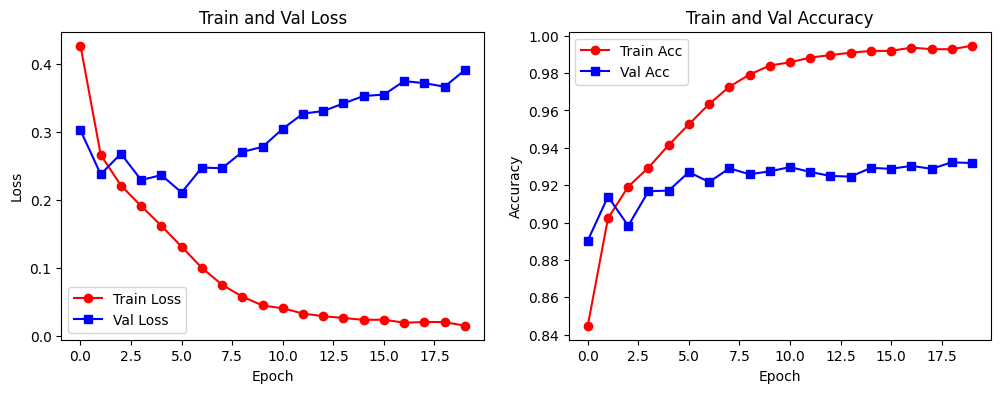

In [4]:
# 训练
import copy
import time
import torchvision.transforms as Transforms
import torchvision.datasets as Datasets
import torch.utils.data as Data
import pandas as pd


def train_val_data_process():
    # 加载数据集
    train_data = Datasets.FashionMNIST(root='./root/autodl-tmp/data', train=True, 
        transform=Transforms.Compose([
            Transforms.Resize((227, 227)),
            Transforms.ToTensor()
        ]), 
        download=True)
    
    # 划分训练集和验证集
    train_data, val_data = Data.random_split(train_data, 
    [round(len(train_data) * 0.8), round(len(train_data) * 0.2)])
    
    train_loader = Data.DataLoader(dataset=train_data, 
        batch_size=32,
        shuffle=True,
        num_workers=4)

    val_loader = Data.DataLoader(dataset=val_data, 
        batch_size=32,
        shuffle=True,
        num_workers=4)
    
    return train_loader, val_loader


def train_model_process(model, train_loader, val_loader, num_epochs=5):
    # 加载模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("当前设备：", device)
    model = model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # 训练损失
    train_loss_all = []
    # 训练准确率
    train_acc_all = []
    # 验证损失
    val_loss_all = []
    # 验证准确率
    val_acc_all = []

    since = time.time()
    # 训练
    for epoch in range(num_epochs):
        
        print(f"Epoch {epoch+1}/{num_epochs} - LR: {optimizer.param_groups[0]['lr']}")
        print('-' * 10)
        
        train_loss = 0.0
        train_corrects = 0.0

        val_loss = 0.0
        val_corrects = 0.0

        train_num = 0
        val_num = 0

        # 训练
        for step, (b_x, b_y) in enumerate(train_loader):
            # 数据移动到设备
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            train_num += b_x.size(0)

            # 模型训练
            model.train()
            outputs = model(b_x)
            # 计算损失
            loss = criterion(outputs, b_y)
            
            # 梯度清零，防止梯度叠加
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()

            # 计算准确率
            pre_lab = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(pre_lab == b_y)
            # 计算损失
            train_loss += loss.item() * b_x.size(0)
            
            # 计算验证损失和准确率
        for step, (b_x, b_y) in enumerate(val_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)

            val_num += b_x.size(0)

            # 模型验证
            model.eval()
            outputs = model(b_x)
            loss = criterion(outputs, b_y)

            # 计算验证损失
            val_loss += loss.item() * b_x.size(0)
            pre_lab = torch.argmax(outputs, dim=1)
            val_corrects += torch.sum(pre_lab == b_y)

        # 计算训练损失和准确率
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)

        print('Train loss: {:.4f} Train acc: {:.4f} | Val loss: {:.4f} Val acc: {:.4f}'
        .format(train_loss_all[-1], train_acc_all[-1], val_loss_all[-1], val_acc_all[-1]))

        # 保存最佳模型参数
    if val_acc_all[-1] > best_acc:
        best_acc = val_acc_all[-1]
        best_model_wts = copy.deepcopy(model.state_dict())
    

    time_elapsed = time.time() - since
    print(f"训练完成，用时 {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # 保存最佳模型
    torch.save(best_model_wts, './root/autodl-tmp/model/resnet_best_model.pth')

    train_process_data = pd.DataFrame({
        'epoch': range(num_epochs),
        'train_loss': train_loss_all,
        'train_acc': train_acc_all,
        'val_loss': val_loss_all,
        'val_acc': val_acc_all
    })
    return train_process_data
    

model = ResNet(in_channels=1, num_classes=10)
train_loader, val_loader = train_val_data_process()
train_process_data = train_model_process(model, train_loader, val_loader, num_epochs=20)

matplot_train_process_data(train_process_data)